In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lineartree import *
from sklearn.linear_model import *
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV

from pandas.plotting import register_matplotlib_converters

In [2]:
### CREATE SYNTHETIC DATA ###

X,y = make_classification(n_samples=8000, n_features=20, n_classes=3, 
                          n_informative=4, n_redundant=6, shift=0,
                          random_state=0)

X.shape, y.shape
register_matplotlib_converters()

In [3]:
### STORE DATA IN DF ###

df = pd.DataFrame(X, columns=[f"c_{c}" for c in range(X.shape[1])], 
                  index=pd.date_range('2021', periods=X.shape[0], freq='D'))

print(df.shape)
df.head()

(8000, 20)


,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18,c_19
2021-01-01,4.287691,-0.358809,0.777817,0.175833,0.248941,2.686354,0.037420,0.003614,-1.244712,2.302351,-0.627346,4.005909,-0.949230,1.996186,-2.124947,-0.856226,-0.177669,-0.866306,0.567518,-0.687878
2021-01-02,-2.444821,0.281751,0.769856,1.890554,0.485304,-1.640004,-1.567687,0.437817,2.605101,1.679222,-0.555384,-3.300566,1.002278,2.219537,1.202828,0.459995,0.377004,-0.091082,-0.468515,-1.105517
2021-01-03,2.199832,-0.728858,-0.851401,1.028180,0.538306,1.624893,-0.489566,0.543877,0.051013,2.013999,-0.843005,1.919138,-0.273925,2.204062,-1.350526,0.228423,-0.954840,-1.790186,1.938162,-0.229806
2021-01-04,-1.020253,0.697211,1.611068,1.249618,0.310183,-0.414572,-1.082014,0.693993,0.991894,0.407220,0.554988,-1.147604,1.706236,1.090488,0.216886,-0.611295,1.273114,-1.792371,-1.634992,-1.054940
2021-01-05,-0.176863,-1.076803,-0.917608,-1.604149,-1.446171,-1.617815,-0.539624,-0.225089,-1.074695,-0.271801,0.947266,-0.923235,-0.714952,-1.070699,1.405238,-0.207820,-0.402361,0.533625,0.698437,-0.298558


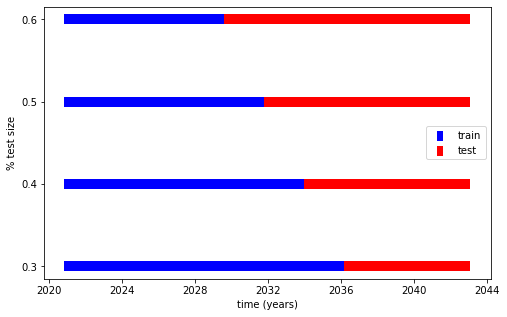

In [4]:
### CREATE AND SHOW TRAIN-TEST SCHEMA ###

test_size = [0.6, 0.5, 0.4, 0.3] 

plt.figure(figsize=(8,5))
for size in test_size:
        
    X_train, X_test = train_test_split(
        df.copy(), test_size=size, shuffle=False)
    
    if size == min(test_size):
        plt.scatter(X_train.index, [size]*len(X_train), 
                    marker='_', lw=10, c='blue', label='train')
        plt.scatter(X_test.index, [size]*len(X_test), 
                    marker='_', lw=10, c='red', label='test')
        plt.legend()
    else:
        plt.scatter(X_train.index, [size]*len(X_train), 
                    marker='_', lw=10, c='blue')
        plt.scatter(X_test.index, [size]*len(X_test), 
                    marker='_', lw=10, c='red')

plt.yticks(np.arange(max(test_size), min(test_size)-0.1, -0.1), test_size)
plt.ylabel('% test size'); plt.xlabel('time (years)'); plt.show()

In [5]:
### EMPTY DICT TO STORE RESULTS ###

results = {
    'DecisionTree': {},
    'LinearModel': {},
    'LinearTree': {},
    'Baseline': {}
}

In [6]:
### FIT MODELS AND STORE RESULTS ###

for size in test_size:
    
    X_train, X_test, y_train, y_test = train_test_split(
        df.copy(), y.copy(), test_size=size, shuffle=False)
    
    model = DummyClassifier(strategy='most_frequent')
    model.fit(X_train, y_train)
    
    results['Baseline'][size] = model.score(X_test, y_test)
    
    model = GridSearchCV(estimator=DecisionTreeClassifier(random_state=33), 
                     param_grid={'max_depth': [3, 6, 8, 10, None], 'min_samples_split': [6, 12, 18]}, 
                     n_jobs=-1, cv=3, refit=True)
    model.fit(X_train, y_train)
    
    results['DecisionTree'][size] = model.score(X_test, y_test)

    model = GridSearchCV(estimator=LinearTreeClassifier(RidgeClassifier()),
                         param_grid={'max_depth': [3, 6, 8], 'min_samples_split': [12, 18]}, 
                         n_jobs=-1, cv=3, refit=True)
    model.fit(X_train, y_train)
    
    results['LinearTree'][size] = model.score(X_test, y_test)
    
    model = GridSearchCV(estimator=RidgeClassifier(),
                         param_grid={'alpha': [1, 3, 6]}, 
                         n_jobs=-1, cv=3, refit=True)
    model.fit(X_train, y_train)
    
    results['LinearModel'][size] = model.score(X_test, y_test)

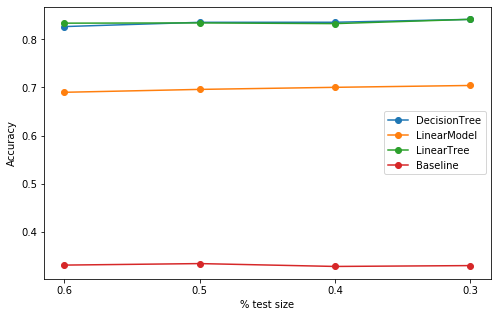

In [7]:
### PLOT RESULTS ###

plt.figure(figsize=(8,5))
for model in results:
    plt.plot(list(results[model].values()), label=model, marker='o')
    
plt.xticks(range(len(results[model])), results[model].keys())
plt.ylabel("Accuracy"); plt.xlabel("% test size")
plt.legend(); plt.show()

# FEATURES SHIFTS

In [8]:
### STORE DATA IN DF ###

X,y = make_classification(n_samples=8000, n_features=20, n_classes=3, 
                          n_informative=4, n_redundant=6, shift=0,
                          random_state=0)

np.random.seed(0)
shift1 = np.random.randint(-3,3, (1,X.shape[1]))
shift2 = np.random.randint(1,6, (1,X.shape[1]))

X[int(X.shape[0]*0.5):int(X.shape[0]*0.8)] += shift1
X[int(X.shape[0]*0.8):] += shift2

df = pd.DataFrame(X, columns=[f"c_{c}" for c in range(X.shape[1])], 
                  index=pd.date_range('2021', periods=X.shape[0], freq='D'))

print(df.shape)
df.head()

(8000, 20)


,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18,c_19
2021-01-01,4.287691,-0.358809,0.777817,0.175833,0.248941,2.686354,0.037420,0.003614,-1.244712,2.302351,-0.627346,4.005909,-0.949230,1.996186,-2.124947,-0.856226,-0.177669,-0.866306,0.567518,-0.687878
2021-01-02,-2.444821,0.281751,0.769856,1.890554,0.485304,-1.640004,-1.567687,0.437817,2.605101,1.679222,-0.555384,-3.300566,1.002278,2.219537,1.202828,0.459995,0.377004,-0.091082,-0.468515,-1.105517
2021-01-03,2.199832,-0.728858,-0.851401,1.028180,0.538306,1.624893,-0.489566,0.543877,0.051013,2.013999,-0.843005,1.919138,-0.273925,2.204062,-1.350526,0.228423,-0.954840,-1.790186,1.938162,-0.229806
2021-01-04,-1.020253,0.697211,1.611068,1.249618,0.310183,-0.414572,-1.082014,0.693993,0.991894,0.407220,0.554988,-1.147604,1.706236,1.090488,0.216886,-0.611295,1.273114,-1.792371,-1.634992,-1.054940
2021-01-05,-0.176863,-1.076803,-0.917608,-1.604149,-1.446171,-1.617815,-0.539624,-0.225089,-1.074695,-0.271801,0.947266,-0.923235,-0.714952,-1.070699,1.405238,-0.207820,-0.402361,0.533625,0.698437,-0.298558


Text(0.5, 0, 'time (years)')

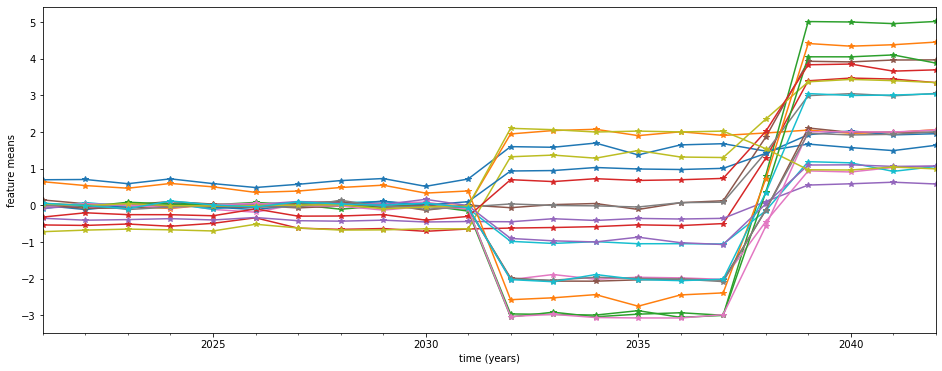

In [9]:
### FEATURE DISTRIBUTIONS OVER TIME ###

df.groupby(df.index.year).mean().set_index(pd.to_datetime(df.index.year.unique(), format='%Y')).plot(
    legend=False, figsize=(16,6), style='-*')
plt.ylabel('feature means'); plt.xlabel('time (years)')

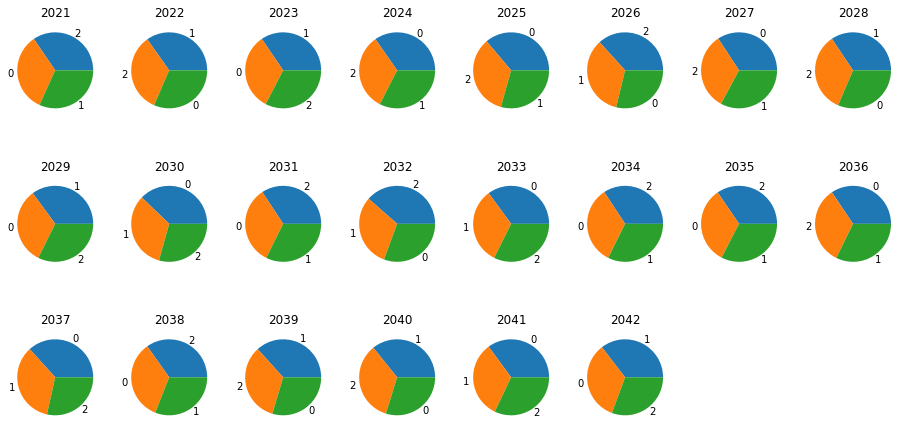

In [10]:
### LABEL DISTRIBUTION OVER TIME ###

plt.figure(figsize=(16,8))

for i,(year,g) in enumerate(pd.Series(y, name='label').groupby(df.index.year)):
    
    plt.subplot(3,8,i+1)
    g.value_counts().plot.pie(title=year)
    plt.axis('off')

In [11]:
### EMPTY DICT TO STORE RESULTS ###

results = {
    'DecisionTree': {},
    'LinearModel': {},
    'LinearTree': {},
    'Baseline': {}
}

In [12]:
### FIT MODELS AND STORE RESULTS ###

for size in test_size:
    
    X_train, X_test, y_train, y_test = train_test_split(
        df.copy(), y.copy(), test_size=size, shuffle=False)
    
    model = DummyClassifier(strategy='most_frequent')
    model.fit(X_train, y_train)
    
    results['Baseline'][size] = model.score(X_test, y_test)
    
    model = GridSearchCV(estimator=DecisionTreeClassifier(random_state=33), 
                     param_grid={'max_depth': [3, 6, 8, 10, None], 'min_samples_split': [6, 12, 18]}, 
                     n_jobs=-1, cv=3, refit=True)
    model.fit(X_train, y_train)
    
    results['DecisionTree'][size] = model.score(X_test, y_test)

    model = GridSearchCV(estimator=LinearTreeClassifier(RidgeClassifier()),
                         param_grid={'max_depth': [3, 6, 8], 'min_samples_split': [12, 18]}, 
                         n_jobs=-1, cv=3, refit=True)
    model.fit(X_train, y_train)
    
    results['LinearTree'][size] = model.score(X_test, y_test)
    
    model = GridSearchCV(estimator=RidgeClassifier(),
                         param_grid={'alpha': [1, 3, 6]}, 
                         n_jobs=-1, cv=3, refit=True)
    model.fit(X_train, y_train)
    
    results['LinearModel'][size] = model.score(X_test, y_test)

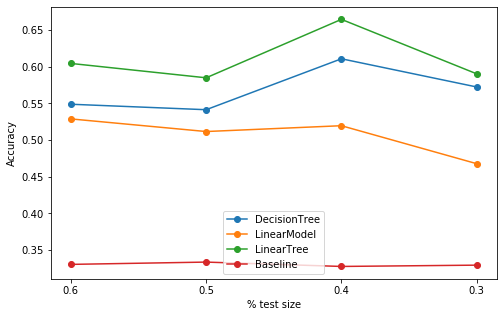

In [13]:
### PLOT RESULTS ###

plt.figure(figsize=(8,5))
for model in results:
    plt.plot(list(results[model].values()), label=model, marker='o')
    
plt.xticks(range(len(results[model])), results[model].keys())
plt.ylabel("Accuracy"); plt.xlabel("% test size")
plt.legend(); plt.show()

# LABELS SHIFTS

In [14]:
### CREATE SYNTHETIC DATA ###

X,y = make_classification(n_samples=8000, n_features=20, n_classes=2, 
                          n_informative=4, n_redundant=6, shift=0,
                          random_state=0)
_,y1 = make_classification(n_samples=8000, n_features=20, n_classes=2, 
                            n_informative=4, n_redundant=6, shift=0,
                            weights=[0.6, 0.4],
                            random_state=0)
_,y2 = make_classification(n_samples=8000, n_features=20, n_classes=2, 
                            n_informative=4, n_redundant=6, shift=0,
                            weights=[0.7, 0.3],
                            random_state=0)

y[int(y.shape[0]*0.5):int(y.shape[0]*0.8)] = y1[int(y.shape[0]*0.5):int(y.shape[0]*0.8)]
y[int(y.shape[0]*0.8):] = y2[int(y.shape[0]*0.8):]

df = pd.DataFrame(X, columns=[f"c_{c}" for c in range(X.shape[1])], 
                  index=pd.date_range('2021', periods=X.shape[0], freq='D'))

print(df.shape)
df.head()

(8000, 20)


,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18,c_19
2021-01-01,0.821383,1.161708,2.831166,1.587163,1.054534,1.296977,-3.709026,-0.907038,-1.526936,1.130235,-0.866657,-1.628032,0.474710,2.570521,-0.585179,1.312589,-2.265808,0.414355,-0.650578,-3.751353
2021-01-02,1.443540,3.187349,0.923683,0.394118,-2.172413,-0.215947,0.666056,1.716370,0.537723,-1.417419,0.931193,1.589129,0.351800,1.497274,-0.756063,0.541655,-1.345804,-1.151544,-1.350107,-0.817080
2021-01-03,0.534494,1.087557,1.497025,0.668065,-0.914374,-1.421591,1.495214,0.254417,1.001146,0.053116,1.183041,0.726687,-0.107988,-3.046624,0.660347,0.282711,-0.196165,0.638087,0.886149,-0.508524
2021-01-04,0.055107,-0.251383,0.413238,0.460047,0.339353,-1.481324,1.303584,0.336805,2.286715,0.200445,-0.222899,0.708315,-0.945581,1.791337,-1.795334,1.193433,0.134012,0.082601,-0.766660,0.100024
2021-01-05,1.540019,3.463820,1.272690,-0.784644,-2.924575,-1.658141,2.712342,0.485971,0.659250,-1.555661,-0.718680,2.470681,0.309902,1.352404,1.798274,0.535998,-0.835954,-0.103250,0.518354,-0.199001


Text(0.5, 0, 'time (years)')

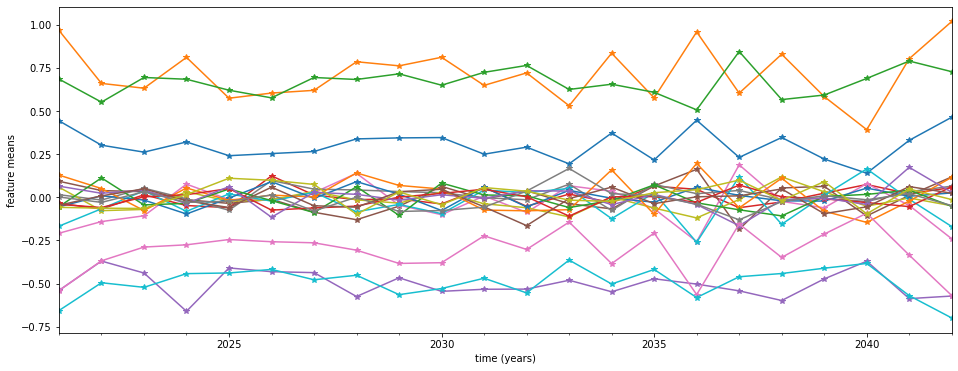

In [15]:
### FEATURE DISTRIBUTIONS OVER TIME ###

df.groupby(df.index.year).mean().set_index(pd.to_datetime(df.index.year.unique(), format='%Y')).plot(
    legend=False, figsize=(16,6), style='-*')
plt.ylabel('feature means'); plt.xlabel('time (years)')

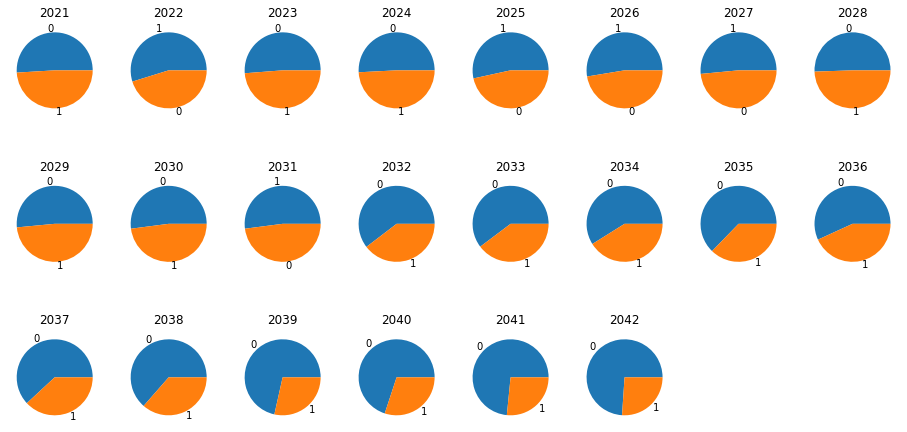

In [16]:
### LABEL DISTRIBUTIONS OVER TIME ###

plt.figure(figsize=(16,8))

for i,(year,g) in enumerate(pd.Series(y, name='label').groupby(df.index.year)):
    
    plt.subplot(3,8,i+1)
    g.value_counts().plot.pie(title=year)
    plt.axis('off')

In [17]:
### EMPTY DICT TO STORE RESULTS ###

results = {
    'DecisionTree': {},
    'LinearModel': {},
    'LinearTree': {},
    'Baseline': {}
}

In [18]:
### FIT MODELS AND STORE RESULTS ###

for size in test_size:
    
    X_train, X_test, y_train, y_test = train_test_split(
        df.copy(), y.copy(), test_size=size, shuffle=False)
    
    model = DummyClassifier(strategy='most_frequent')
    model.fit(X_train, y_train)
    
    results['Baseline'][size] = model.score(X_test, y_test)
    
    model = GridSearchCV(estimator=DecisionTreeClassifier(random_state=33), 
                     param_grid={'max_depth': [3, 6, 8, 10, None], 'min_samples_split': [6, 12, 18]}, 
                     n_jobs=-1, cv=3, refit=True)
    model.fit(X_train, y_train)
    
    results['DecisionTree'][size] = model.score(X_test, y_test)

    model = GridSearchCV(estimator=LinearTreeClassifier(RidgeClassifier()),
                         param_grid={'max_depth': [3, 6, 8], 'min_samples_split': [12, 18]}, 
                         n_jobs=-1, cv=3, refit=True)
    model.fit(X_train, y_train)
    
    results['LinearTree'][size] = model.score(X_test, y_test)
    
    model = GridSearchCV(estimator=RidgeClassifier(),
                         param_grid={'alpha': [1, 3, 6]}, 
                         n_jobs=-1, cv=3, refit=True)
    model.fit(X_train, y_train)
    
    results['LinearModel'][size] = model.score(X_test, y_test)

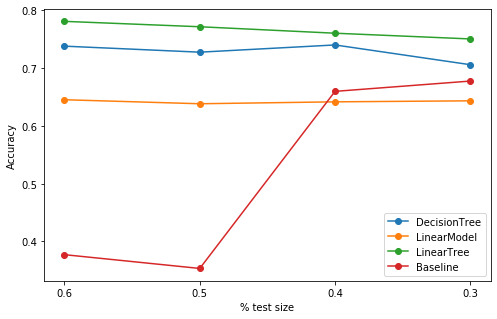

In [19]:
### PLOT RESULTS ###

plt.figure(figsize=(8,5))
for model in results:
    plt.plot(list(results[model].values()), label=model, marker='o')
plt.xticks(range(len(results[model])), results[model].keys())
plt.ylabel("Accuracy"); plt.xlabel("% test size")
plt.legend(); plt.show()